In [3]:
# =============================
# XGB + OPTUNA TIME SERIES PIPELINE
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import optuna
import warnings

In [4]:
warnings.filterwarnings("ignore")

In [5]:
dim_reduced_df = pd.read_csv('../data/feature-engineered/df_2_reduced.csv')

In [6]:
# -----------------------------
# CONFIG
# -----------------------------
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]

In [15]:
# -----------------------------
# DATA SPLIT (same as your Prophet pipeline)
# -----------------------------
def prepare_data_split(df, date_col='date', split_year=2020):
    df[date_col] = pd.to_datetime(df[date_col])
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    train_data = df_sorted[df_sorted[date_col].dt.year < split_year].copy()
    test_data  = df_sorted[df_sorted[date_col].dt.year >= split_year].copy()
    print(f"Training: {len(train_data)} rows | Testing: {len(test_data)} rows")
    return train_data, test_data

# -----------------------------
# FEATURE ENGINEERING
# -----------------------------
def add_target_lags(df, target, lags=(1, 3, 6, 12)):
    """Create lag features for the given target ONLY (avoids leakage)."""
    df = df.copy()
    for l in lags:
        df[f"{target}_lag{l}"] = df[target].shift(l)
    return df

def clean_exog_cols(df, cols):
    """Replace inf and fill NaN values more aggressively."""
    cdf = df[['date'] + cols].copy()
    for c in cols:
        if c in cdf.columns:  # Safety check
            cdf[c] = cdf[c].replace([np.inf, -np.inf], np.nan)
            # More aggressive filling: forward fill, then backward fill, then median fill
            cdf[c] = cdf[c].fillna(method='ffill').fillna(method='bfill')
            # If still NaN (e.g., first few rows), fill with median
            if cdf[c].isna().any():
                cdf[c] = cdf[c].fillna(cdf[c].median())
            # If still NaN (all NaN column), fill with 0
            if cdf[c].isna().any():
                cdf[c] = cdf[c].fillna(0)
    return cdf

# -----------------------------
# TRAIN/VAL SPLIT FOR EARLY STOP
# -----------------------------
def time_val_split(train_df, val_ratio=0.2):
    """Keep order; last portion as validation."""
    n = len(train_df)
    cut = int(np.floor(n * (1 - val_ratio)))
    return train_df.iloc[:cut].copy(), train_df.iloc[cut:].copy()

# -----------------------------
# OPTUNA OBJECTIVE
# -----------------------------
def make_objective(X_train, y_train, X_val, y_val, random_state=42):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 2, 8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),
            "random_state": random_state,
            "objective": "reg:squarederror",
            "tree_method": "hist",
            "early_stopping_rounds": 100,  # Move to params
        }
        model = XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        # Use the best iteration chosen by early stopping implicitly
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        return rmse
    return objective

# -----------------------------
# TRAIN + PREDICT + EVAL
# -----------------------------
def train_predict_xgb_optuna(train_df, test_df, target, exog_cols, lags=(1,3,6,12), n_trials=50, seed=42, verbose=True):
    """
    Build lag features for target, tune with Optuna on a time-aware val split,
    retrain on full training, predict on test, return preds and metrics.
    """
    if target not in train_df.columns:
        if verbose:
            print(f"❌ Target {target} not found in training data")
        return None, None, None, None, None

    # Debug: Check data before processing
    if verbose:
        print(f"🔍 DEBUG: Initial train shape: {train_df.shape}, test shape: {test_df.shape}")
        print(f"🔍 DEBUG: Target {target} - train nulls: {train_df[target].isna().sum()}, test nulls: {test_df[target].isna().sum()}")

    # 1) Build lag features (on concatenated df to align indices cleanly)
    df_all = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    df_all = add_target_lags(df_all, target, lags=lags)

    if verbose:
        print(f"🔍 DEBUG: After adding lags, shape: {df_all.shape}")
        lag_cols = [f"{target}_lag{l}" for l in lags]
        print(f"🔍 DEBUG: Lag column nulls: {df_all[lag_cols].isna().sum().to_dict()}")

    # 2) Prepare feature columns 
    feature_cols = exog_cols + [f"{target}_lag{l}" for l in lags]
    # Filter to only include columns that actually exist
    feature_cols = [c for c in feature_cols if c in df_all.columns]
    
    if verbose:
        print(f"🔍 DEBUG: Using {len(feature_cols)} features: {feature_cols[:5]}..." if len(feature_cols) > 5 else f"🔍 DEBUG: Using {len(feature_cols)} features: {feature_cols}")

    use_cols = ['date', target] + feature_cols
    df_all = df_all[use_cols].copy()

    # Clean exogenous columns
    if feature_cols:  # Only clean if we have features
        if verbose:
            print(f"🔍 DEBUG: Before cleaning - NaN counts in features:")
            for col in feature_cols[:10]:  # Show first 10 feature columns
                if col in df_all.columns:
                    nan_count = df_all[col].isna().sum()
                    print(f"   {col}: {nan_count} NaNs")
        
        exog_clean = clean_exog_cols(df_all, feature_cols)
        df_all = df_all[['date', target]].merge(exog_clean, on='date', how='inner')
        
        if verbose:
            print(f"🔍 DEBUG: After cleaning - NaN counts in features:")
            for col in feature_cols[:10]:  # Show first 10 feature columns
                if col in df_all.columns:
                    nan_count = df_all[col].isna().sum()
                    print(f"   {col}: {nan_count} NaNs")

    if verbose:
        print(f"🔍 DEBUG: After cleaning, shape: {df_all.shape}")
        print(f"🔍 DEBUG: Total nulls in df_all: {df_all.isna().sum().sum()}")

    # Drop rows with NaNs (but be more strategic about it)
    initial_rows = len(df_all)
    # Check how many columns have NaNs before dropping
    nan_counts_by_col = df_all.isna().sum()
    if verbose:
        problem_cols = nan_counts_by_col[nan_counts_by_col > 0]
        if len(problem_cols) > 0:
            print(f"🔍 DEBUG: Columns with NaNs before dropping: {problem_cols.to_dict()}")
    
    df_all = df_all.dropna().reset_index(drop=True)
    final_rows = len(df_all)
    
    if verbose:
        print(f"🔍 DEBUG: Dropped {initial_rows - final_rows} rows with NaN (kept {final_rows})")

    if final_rows == 0:
        if verbose:
            print(f"❌ No rows left after dropping NaNs for {target}")
        return None, None, None, None, None

    # 4) Re-split by date into train/test after lagging/cleaning
    train_mask = df_all['date'] < pd.Timestamp('2020-01-01')
    test_mask = df_all['date'] >= pd.Timestamp('2020-01-01')

    df_tr = df_all.loc[train_mask].copy()
    df_te = df_all.loc[test_mask].copy()

    if verbose:
        print(f"🔍 DEBUG: After date split - train: {len(df_tr)}, test: {len(df_te)}")

    if len(df_tr) < 20:  # Too small to proceed
        if verbose:
            print(f"⚠️  Very small training set after lagging for {target}: {len(df_tr)} rows")
        return None, None, None, None, None
            
    if len(df_te) == 0:
        if verbose:
            print(f"⚠️  No test rows after 2020 for {target}")
        return None, None, None, None, None

    X_tr_full = df_tr[feature_cols].values
    y_tr_full = df_tr[target].values
    X_te = df_te[feature_cols].values
    y_te = df_te[target].values

    # 5) Time-aware validation split inside training for early stopping
    tr_sub, val_sub = time_val_split(df_tr)
    X_tr = tr_sub[feature_cols].values
    y_tr = tr_sub[target].values
    X_val = val_sub[feature_cols].values
    y_val = val_sub[target].values

    # 6) Optuna tuning
    study = optuna.create_study(direction="minimize")
    study.optimize(make_objective(X_tr, y_tr, X_val, y_val, random_state=seed), n_trials=n_trials, show_progress_bar=False)
    best_params = study.best_params
    if verbose:
        print(f"🔧 Best params for {target}: {best_params}")
        print(f"   Best val RMSE: {study.best_value:.4f}")

    # 7) Retrain on FULL training (train+val) with best params and early stopping using last 20% as val
    # (recreate split to feed eval_set)
    tr_df_sub, val_df_sub = time_val_split(df_tr)
    X_tr2, y_tr2 = tr_df_sub[feature_cols].values, tr_df_sub[target].values
    X_val2, y_val2 = val_df_sub[feature_cols].values, val_df_sub[target].values

    model = XGBRegressor(
        **{k: v for k, v in best_params.items() if k not in ["random_state", "early_stopping_rounds"]},
        random_state=seed,
        objective="reg:squarederror",
        tree_method="hist",
        early_stopping_rounds=100
    )
    model.fit(
        X_tr2, y_tr2,
        eval_set=[(X_val2, y_val2)],
        verbose=False
    )

    # 8) Predict on TEST
    y_pred = model.predict(X_te)

    # 9) Metrics
    mae = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    def safe_mape(y_true, y_hat, eps=1e-8):
        return float(np.mean(np.abs((y_true - y_hat) / np.maximum(np.abs(y_true), eps))) * 100.0)
    mape = safe_mape(y_te, y_pred)

    # 10) Plot Actual vs Forecast on test range
    plt.figure(figsize=(10,5))
    plt.plot(df_te['date'], y_te, label='Actual', linewidth=2)
    plt.plot(df_te['date'], y_pred, label='Forecast', linewidth=2)
    plt.title(f"XGB Forecast vs Actual — {target}")
    plt.xlabel("Date"); plt.ylabel(target)
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.show()

    return model, df_te[['date']].assign(actual=y_te, forecast=y_pred), mae, rmse, mape

# -----------------------------
# RUN PIPELINE
# -----------------------------
def run_xgb_optuna_pipeline(
    df,
    financial_indicators,
    recession_targets,
    lags=(1,3,6,12),
    n_trials=40,
    include_exog=True,
    plot_results=True,
    seed=42
):
    """
    - Splits by date (<2020 train, >=2020 test)
    - For each target in financial_indicators:
        * builds lag features for that target,
        * uses all non-target, non-recession, non-date columns as exogenous (if include_exog=True),
        * tunes XGB with Optuna,
        * predicts on 2020+,
        * collects metrics.
    """
    # Base split (for reporting only)
    train_data, test_data = prepare_data_split(df)

    # Define exogenous columns ONCE (exclude date, all financial indicators, and recession targets)
    exog_cols = []
    if include_exog:
        exog_cols = [
            c for c in df.columns
            if c not in (['date'] + financial_indicators + recession_targets)
        ]
        print(f"🔧 Using {len(exog_cols)} exogenous features (excludes recession targets & targets)")

    metrics_rows = []
    forecasts = {}

    for target in financial_indicators:
        print("\n" + "="*60)
        print(f"XGBoost + Optuna Forecasting: {target}")
        print("="*60)

        model, test_pred_df, mae, rmse, mape = train_predict_xgb_optuna(
            train_data, test_data, target,
            exog_cols=exog_cols,
            lags=lags,
            n_trials=n_trials,
            seed=seed,
            verbose=True
        )

        if model is None:
            print(f"❌ Skipping {target} due to data issues.")
            continue

        forecasts[target] = test_pred_df
        metrics_rows.append({
            "Indicator": target,
            "MAE": round(mae, 4),
            "RMSE": round(rmse, 4),
            "MAPE_%": round(mape, 4)
        })

    # Handle case where no models succeeded
    if not metrics_rows:
        print("\n❌ No models succeeded. Check your data quality and feature engineering.")
        return {
            "metrics": pd.DataFrame(columns=["MAE", "RMSE", "MAPE_%"]),
            "forecasts": {}
        }

    metrics_df = pd.DataFrame(metrics_rows).set_index("Indicator").sort_index()
    print("\n📊 Forecast Performance Metrics (TEST: 2020+)")
    print(metrics_df)

    return {
        "metrics": metrics_df,
        "forecasts": forecasts
    }

[I 2025-08-28 10:15:57,748] A new study created in memory with name: no-name-3a49d429-c838-4eac-b0a9-cde2a939531b
[I 2025-08-28 10:15:57,933] Trial 0 finished with value: 0.723455245206717 and parameters: {'n_estimators': 268, 'learning_rate': 0.1193480133827622, 'max_depth': 6, 'min_child_weight': 3.0049857592349025, 'subsample': 0.8202501801448652, 'colsample_bytree': 0.8963612028597437, 'gamma': 4.623613662945756, 'reg_alpha': 2.616559058879871, 'reg_lambda': 2.137012784554687}. Best is trial 0 with value: 0.723455245206717.


Training: 635 rows | Testing: 65 rows
🔧 Using 35 exogenous features (excludes recession targets & targets)

XGBoost + Optuna Forecasting: 1_year_rate
🔍 DEBUG: Initial train shape: (635, 52), test shape: (65, 52)
🔍 DEBUG: Target 1_year_rate - train nulls: 79, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 56)
🔍 DEBUG: Lag column nulls: {'1_year_rate_lag1': 80, '1_year_rate_lag3': 82, '1_year_rate_lag6': 85, '1_year_rate_lag12': 91}
🔍 DEBUG: Using 39 features: ['seasonally_adjusted_CPI', 'CPI_trend', 'seasonally_adjusted_unemployment_rate', 'INDPRO_trend', 'seasonally_adjusted_INDPRO']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs
🔍 DEBUG: After cleaning - NaN counts in feature

[I 2025-08-28 10:15:58,047] Trial 1 finished with value: 0.4777510040125041 and parameters: {'n_estimators': 886, 'learning_rate': 0.24644042372042982, 'max_depth': 3, 'min_child_weight': 1.2786552525905965, 'subsample': 0.9201232882605115, 'colsample_bytree': 0.8056707624658469, 'gamma': 0.057655481975174006, 'reg_alpha': 1.3656999051649399, 'reg_lambda': 3.1079829031541983}. Best is trial 1 with value: 0.4777510040125041.
[I 2025-08-28 10:15:58,375] Trial 2 finished with value: 0.6500266964081578 and parameters: {'n_estimators': 1301, 'learning_rate': 0.02431255211794864, 'max_depth': 4, 'min_child_weight': 9.869248839444971, 'subsample': 0.7382532595277765, 'colsample_bytree': 0.7536453398537666, 'gamma': 4.965882594964647, 'reg_alpha': 1.1332980464836895, 'reg_lambda': 1.331413695869543}. Best is trial 1 with value: 0.4777510040125041.
[I 2025-08-28 10:15:59,134] Trial 3 finished with value: 0.5816117939458775 and parameters: {'n_estimators': 1229, 'learning_rate': 0.01819734104507

🔧 Best params for 1_year_rate: {'n_estimators': 1352, 'learning_rate': 0.025472152612690202, 'max_depth': 7, 'min_child_weight': 8.998239568669678, 'subsample': 0.9179582480739746, 'colsample_bytree': 0.9591087312526269, 'gamma': 0.26585871094380464, 'reg_alpha': 0.0056661372189719394, 'reg_lambda': 3.646724905980421}
   Best val RMSE: 0.4763


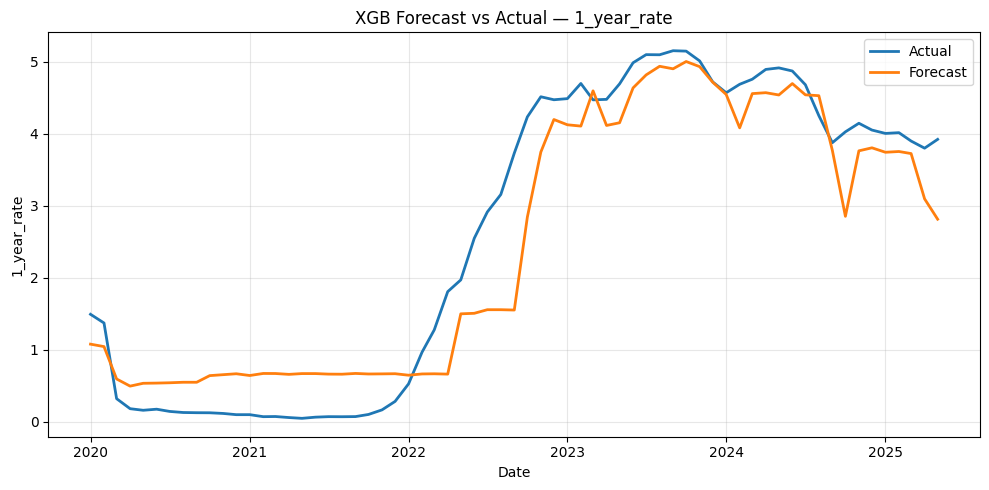

[I 2025-08-28 10:16:15,346] A new study created in memory with name: no-name-8a6b2df1-a40c-4a1f-b519-57723371cdab



XGBoost + Optuna Forecasting: 3_months_rate
🔍 DEBUG: Initial train shape: (635, 52), test shape: (65, 52)
🔍 DEBUG: Target 3_months_rate - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 56)
🔍 DEBUG: Lag column nulls: {'3_months_rate_lag1': 1, '3_months_rate_lag3': 3, '3_months_rate_lag6': 6, '3_months_rate_lag12': 12}
🔍 DEBUG: Using 39 features: ['seasonally_adjusted_CPI', 'CPI_trend', 'seasonally_adjusted_unemployment_rate', 'INDPRO_trend', 'seasonally_adjusted_INDPRO']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate

[I 2025-08-28 10:16:15,571] Trial 0 finished with value: 1.0479885492598602 and parameters: {'n_estimators': 1218, 'learning_rate': 0.1397867758906084, 'max_depth': 6, 'min_child_weight': 7.649066617072627, 'subsample': 0.7019694681788493, 'colsample_bytree': 0.9444625916452383, 'gamma': 1.8858937848234398, 'reg_alpha': 4.93077386418314, 'reg_lambda': 2.873562865035544}. Best is trial 0 with value: 1.0479885492598602.
[I 2025-08-28 10:16:15,726] Trial 1 finished with value: 1.131003560345085 and parameters: {'n_estimators': 1639, 'learning_rate': 0.07140055093672745, 'max_depth': 7, 'min_child_weight': 8.108934592845774, 'subsample': 0.6846853237782983, 'colsample_bytree': 0.9086188626594589, 'gamma': 4.899901381897273, 'reg_alpha': 3.149692965136527, 'reg_lambda': 3.0646858440895333}. Best is trial 0 with value: 1.0479885492598602.
[I 2025-08-28 10:16:16,070] Trial 2 finished with value: 1.0794397403511702 and parameters: {'n_estimators': 1989, 'learning_rate': 0.02185159621070191, 'm

🔧 Best params for 3_months_rate: {'n_estimators': 1876, 'learning_rate': 0.01255731132274201, 'max_depth': 5, 'min_child_weight': 8.477937861262728, 'subsample': 0.9949191946307664, 'colsample_bytree': 0.6039582033214489, 'gamma': 0.09170249868290987, 'reg_alpha': 0.2704677776676306, 'reg_lambda': 0.5052967780772804}
   Best val RMSE: 0.4687


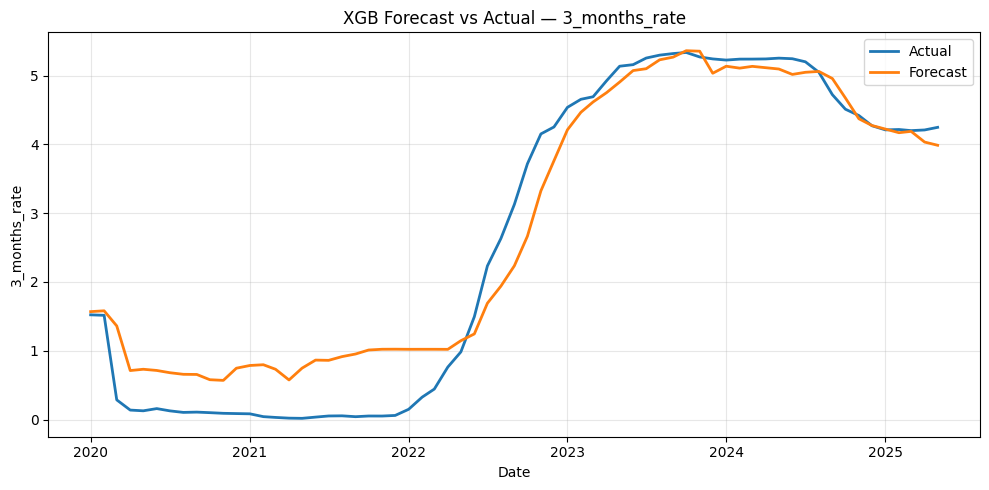

[I 2025-08-28 10:16:40,771] A new study created in memory with name: no-name-ad89617f-7093-4ef7-9266-f3b51a5112f5



XGBoost + Optuna Forecasting: 6_months_rate
🔍 DEBUG: Initial train shape: (635, 52), test shape: (65, 52)
🔍 DEBUG: Target 6_months_rate - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 56)
🔍 DEBUG: Lag column nulls: {'6_months_rate_lag1': 1, '6_months_rate_lag3': 3, '6_months_rate_lag6': 6, '6_months_rate_lag12': 12}
🔍 DEBUG: Using 39 features: ['seasonally_adjusted_CPI', 'CPI_trend', 'seasonally_adjusted_unemployment_rate', 'INDPRO_trend', 'seasonally_adjusted_INDPRO']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate

[I 2025-08-28 10:16:41,105] Trial 0 finished with value: 0.9974402475559094 and parameters: {'n_estimators': 1659, 'learning_rate': 0.048851575075163696, 'max_depth': 5, 'min_child_weight': 7.659208221864053, 'subsample': 0.8720489111027576, 'colsample_bytree': 0.6472619139554999, 'gamma': 1.4655619944052471, 'reg_alpha': 2.3776294374422173, 'reg_lambda': 4.935215577726273}. Best is trial 0 with value: 0.9974402475559094.
[I 2025-08-28 10:16:41,436] Trial 1 finished with value: 1.2004423082113689 and parameters: {'n_estimators': 225, 'learning_rate': 0.021567782695462445, 'max_depth': 4, 'min_child_weight': 4.212436083021472, 'subsample': 0.7965138022637168, 'colsample_bytree': 0.7540571271520906, 'gamma': 0.08669168177317832, 'reg_alpha': 4.579701675521365, 'reg_lambda': 0.893476266277557}. Best is trial 0 with value: 0.9974402475559094.
[I 2025-08-28 10:16:42,077] Trial 2 finished with value: 0.9331368484031093 and parameters: {'n_estimators': 559, 'learning_rate': 0.0138429189858165

🔧 Best params for 6_months_rate: {'n_estimators': 1627, 'learning_rate': 0.2619556704776827, 'max_depth': 7, 'min_child_weight': 3.2734067560862785, 'subsample': 0.6817577657126067, 'colsample_bytree': 0.8986119790237213, 'gamma': 0.7630456893314651, 'reg_alpha': 0.010948531132999234, 'reg_lambda': 3.643756974755914}
   Best val RMSE: 0.6741


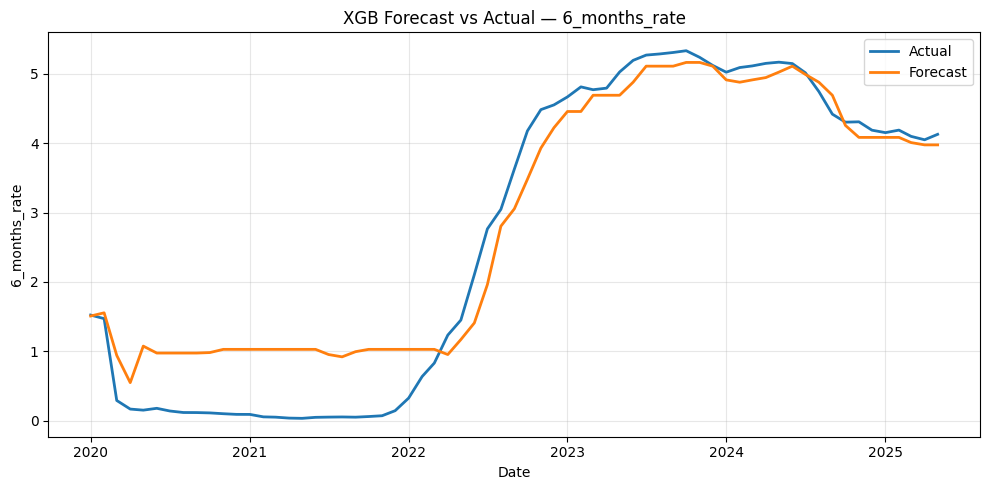


XGBoost + Optuna Forecasting: CPI
🔍 DEBUG: Initial train shape: (635, 52), test shape: (65, 52)
🔍 DEBUG: Target CPI - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 56)
🔍 DEBUG: Lag column nulls: {'CPI_lag1': 1, 'CPI_lag3': 3, 'CPI_lag6': 6, 'CPI_lag12': 12}
🔍 DEBUG: Using 39 features: ['seasonally_adjusted_CPI', 'CPI_trend', 'seasonally_adjusted_unemployment_rate', 'INDPRO_trend', 'seasonally_adjusted_INDPRO']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs


[I 2025-08-28 10:16:53,399] A new study created in memory with name: no-name-87a72111-754d-4cd7-99e9-4845a1e08735


🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs
🔍 DEBUG: After cleaning, shape: (700, 41)
🔍 DEBUG: Total nulls in df_all: 0
🔍 DEBUG: Dropped 0 rows with NaN (kept 700)
🔍 DEBUG: After date split - train: 635, test: 65


[I 2025-08-28 10:16:53,745] Trial 0 finished with value: 25.000334504714598 and parameters: {'n_estimators': 880, 'learning_rate': 0.06701550886378307, 'max_depth': 7, 'min_child_weight': 8.436425415839828, 'subsample': 0.9148527775948005, 'colsample_bytree': 0.7598513101581701, 'gamma': 1.8790301899194684, 'reg_alpha': 0.8854561427795293, 'reg_lambda': 3.9171195828891423}. Best is trial 0 with value: 25.000334504714598.
[I 2025-08-28 10:16:53,935] Trial 1 finished with value: 24.708073650027863 and parameters: {'n_estimators': 1512, 'learning_rate': 0.28390558813728495, 'max_depth': 2, 'min_child_weight': 5.812490585962399, 'subsample': 0.672549848663342, 'colsample_bytree': 0.6152176613133974, 'gamma': 1.9022780083554762, 'reg_alpha': 1.4894649241047868, 'reg_lambda': 1.7765588635760503}. Best is trial 1 with value: 24.708073650027863.
[I 2025-08-28 10:16:54,204] Trial 2 finished with value: 24.017433528645178 and parameters: {'n_estimators': 1715, 'learning_rate': 0.0585263289379267

🔧 Best params for CPI: {'n_estimators': 714, 'learning_rate': 0.04768899697189304, 'max_depth': 8, 'min_child_weight': 3.6900476960084423, 'subsample': 0.884314747697006, 'colsample_bytree': 0.9389077863536337, 'gamma': 0.940742420696427, 'reg_alpha': 2.726732245281962, 'reg_lambda': 3.630575280422928}
   Best val RMSE: 23.1590


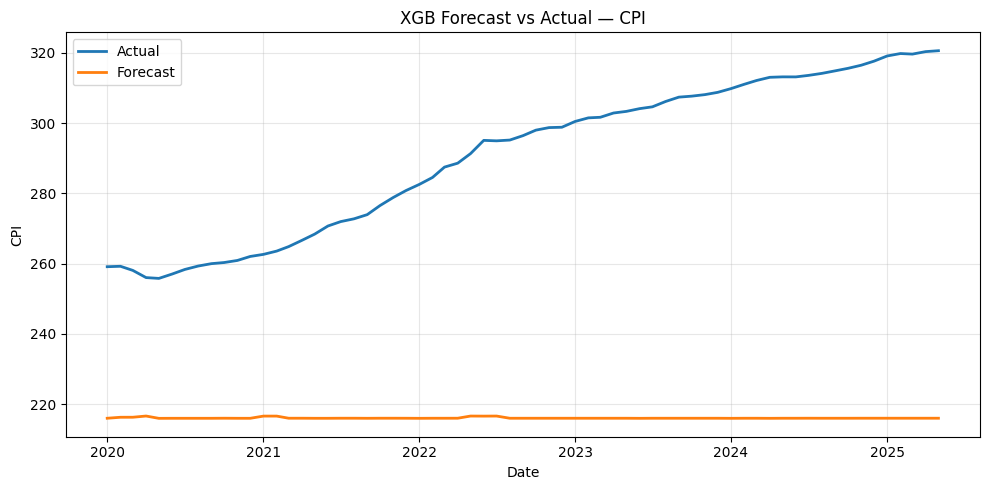

[I 2025-08-28 10:17:10,658] A new study created in memory with name: no-name-40a3bd31-de3e-4eb4-8cdd-6faf1e64bf9b
[I 2025-08-28 10:17:10,817] Trial 0 finished with value: 0.9831568281082571 and parameters: {'n_estimators': 825, 'learning_rate': 0.14071081983356618, 'max_depth': 8, 'min_child_weight': 8.808844376239431, 'subsample': 0.8141573095596841, 'colsample_bytree': 0.7542829632662388, 'gamma': 4.121498791282823, 'reg_alpha': 0.930945529080624, 'reg_lambda': 1.2725842603712387}. Best is trial 0 with value: 0.9831568281082571.



XGBoost + Optuna Forecasting: INDPRO
🔍 DEBUG: Initial train shape: (635, 52), test shape: (65, 52)
🔍 DEBUG: Target INDPRO - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 56)
🔍 DEBUG: Lag column nulls: {'INDPRO_lag1': 1, 'INDPRO_lag3': 3, 'INDPRO_lag6': 6, 'INDPRO_lag12': 12}
🔍 DEBUG: Using 39 features: ['seasonally_adjusted_CPI', 'CPI_trend', 'seasonally_adjusted_unemployment_rate', 'INDPRO_trend', 'seasonally_adjusted_INDPRO']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   season

[I 2025-08-28 10:17:11,352] Trial 1 finished with value: 0.8431038927714923 and parameters: {'n_estimators': 900, 'learning_rate': 0.046908981053934505, 'max_depth': 8, 'min_child_weight': 4.176834493415705, 'subsample': 0.9644532603885766, 'colsample_bytree': 0.8011146739566274, 'gamma': 0.09952653637217201, 'reg_alpha': 2.036232239232259, 'reg_lambda': 2.7978906872981755}. Best is trial 1 with value: 0.8431038927714923.
[I 2025-08-28 10:17:11,663] Trial 2 finished with value: 0.9084240958007429 and parameters: {'n_estimators': 581, 'learning_rate': 0.11778838039153951, 'max_depth': 6, 'min_child_weight': 6.425903342111755, 'subsample': 0.7112735892505114, 'colsample_bytree': 0.6435050120368058, 'gamma': 0.5745126615747836, 'reg_alpha': 0.6954157099871222, 'reg_lambda': 1.1281533208272636}. Best is trial 1 with value: 0.8431038927714923.
[I 2025-08-28 10:17:12,595] Trial 3 finished with value: 1.1434135909135508 and parameters: {'n_estimators': 675, 'learning_rate': 0.0107042233205773

🔧 Best params for INDPRO: {'n_estimators': 1056, 'learning_rate': 0.059249574270891066, 'max_depth': 4, 'min_child_weight': 9.545138547204022, 'subsample': 0.8279659780165582, 'colsample_bytree': 0.864760373899033, 'gamma': 0.008429719129078125, 'reg_alpha': 0.3470410694948751, 'reg_lambda': 1.072313437709993}
   Best val RMSE: 0.7559


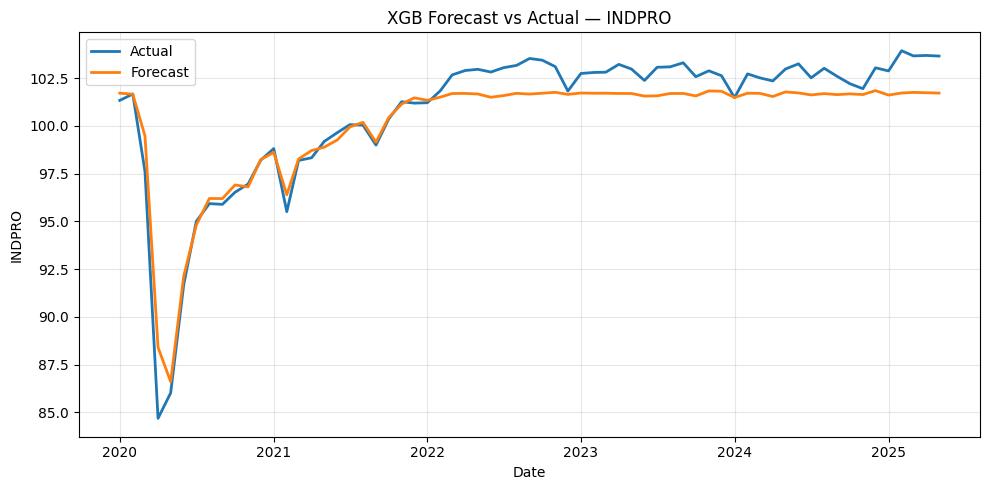

[I 2025-08-28 10:17:26,658] A new study created in memory with name: no-name-75b23343-e145-46aa-8516-1818e1c2fc8f



XGBoost + Optuna Forecasting: 10_year_rate
🔍 DEBUG: Initial train shape: (635, 52), test shape: (65, 52)
🔍 DEBUG: Target 10_year_rate - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 56)
🔍 DEBUG: Lag column nulls: {'10_year_rate_lag1': 1, '10_year_rate_lag3': 3, '10_year_rate_lag6': 6, '10_year_rate_lag12': 12}
🔍 DEBUG: Using 39 features: ['seasonally_adjusted_CPI', 'CPI_trend', 'seasonally_adjusted_unemployment_rate', 'INDPRO_trend', 'seasonally_adjusted_INDPRO']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 Na

[I 2025-08-28 10:17:27,227] Trial 0 finished with value: 1.2900506767325426 and parameters: {'n_estimators': 1766, 'learning_rate': 0.03404737668736242, 'max_depth': 2, 'min_child_weight': 8.786023795126894, 'subsample': 0.9469412572078818, 'colsample_bytree': 0.8302547456031574, 'gamma': 0.24951022249677157, 'reg_alpha': 2.1453171259280293, 'reg_lambda': 0.7905715683927732}. Best is trial 0 with value: 1.2900506767325426.
[I 2025-08-28 10:17:27,492] Trial 1 finished with value: 1.8027073933956541 and parameters: {'n_estimators': 229, 'learning_rate': 0.012219608681053758, 'max_depth': 8, 'min_child_weight': 7.080780562470471, 'subsample': 0.6962697325600893, 'colsample_bytree': 0.6241667982492678, 'gamma': 2.9001353588281873, 'reg_alpha': 0.4585185101528183, 'reg_lambda': 4.056191384610591}. Best is trial 0 with value: 1.2900506767325426.
[I 2025-08-28 10:17:27,592] Trial 2 finished with value: 1.3527780188895775 and parameters: {'n_estimators': 657, 'learning_rate': 0.109124235608301

🔧 Best params for 10_year_rate: {'n_estimators': 231, 'learning_rate': 0.2390771592619865, 'max_depth': 4, 'min_child_weight': 6.3100603759017195, 'subsample': 0.6142673186746427, 'colsample_bytree': 0.9256045507194112, 'gamma': 2.6492260633811533, 'reg_alpha': 0.43060196696746816, 'reg_lambda': 1.5039962222104186}
   Best val RMSE: 1.2114


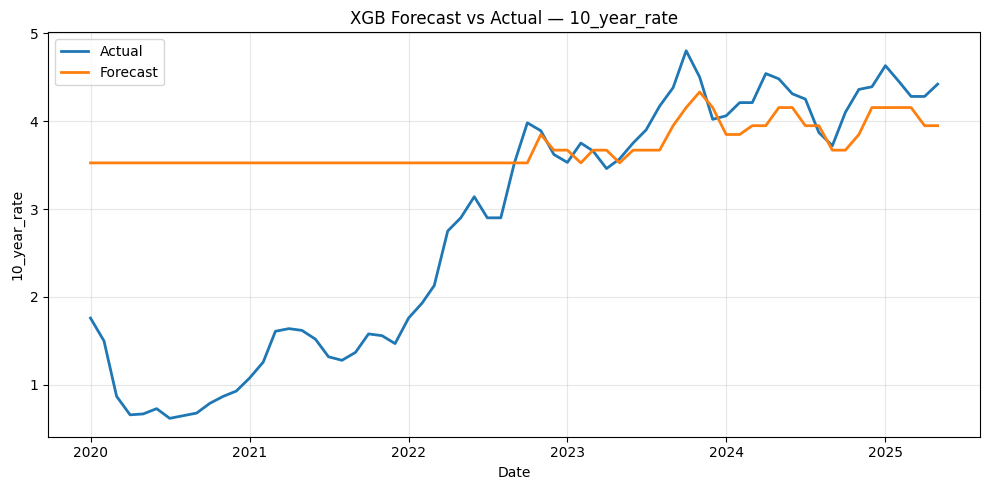


XGBoost + Optuna Forecasting: share_price
🔍 DEBUG: Initial train shape: (635, 52), test shape: (65, 52)
🔍 DEBUG: Target share_price - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 56)
🔍 DEBUG: Lag column nulls: {'share_price_lag1': 1, 'share_price_lag3': 3, 'share_price_lag6': 6, 'share_price_lag12': 12}
🔍 DEBUG: Using 39 features: ['seasonally_adjusted_CPI', 'CPI_trend', 'seasonally_adjusted_unemployment_rate', 'INDPRO_trend', 'seasonally_adjusted_INDPRO']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs


[I 2025-08-28 10:17:36,024] A new study created in memory with name: no-name-502ca8fc-0a5a-4eae-ab01-e158d753595f


🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs
🔍 DEBUG: After cleaning, shape: (700, 41)
🔍 DEBUG: Total nulls in df_all: 0
🔍 DEBUG: Dropped 0 rows with NaN (kept 700)
🔍 DEBUG: After date split - train: 635, test: 65


[I 2025-08-28 10:17:36,229] Trial 0 finished with value: 0.6942930961483269 and parameters: {'n_estimators': 1742, 'learning_rate': 0.2786216732234221, 'max_depth': 5, 'min_child_weight': 4.793510242876339, 'subsample': 0.7308258061557212, 'colsample_bytree': 0.9086310013780979, 'gamma': 4.001235289257539, 'reg_alpha': 2.980099872355861, 'reg_lambda': 1.6014650919679974}. Best is trial 0 with value: 0.6942930961483269.
[I 2025-08-28 10:17:36,366] Trial 1 finished with value: 0.47614269165866996 and parameters: {'n_estimators': 1065, 'learning_rate': 0.190310007217558, 'max_depth': 2, 'min_child_weight': 9.789761375897292, 'subsample': 0.7764615610284099, 'colsample_bytree': 0.9649208893463092, 'gamma': 0.13147347535986453, 'reg_alpha': 3.8308629641027454, 'reg_lambda': 3.0651280064314546}. Best is trial 1 with value: 0.47614269165866996.
[I 2025-08-28 10:17:36,713] Trial 2 finished with value: 0.5406490885867259 and parameters: {'n_estimators': 1828, 'learning_rate': 0.0209681445143972

🔧 Best params for share_price: {'n_estimators': 1396, 'learning_rate': 0.08823929851776609, 'max_depth': 4, 'min_child_weight': 8.204937104916631, 'subsample': 0.7113597226645458, 'colsample_bytree': 0.6249983300088827, 'gamma': 0.058247107745776856, 'reg_alpha': 0.5406302932277113, 'reg_lambda': 4.748355145090315}
   Best val RMSE: 0.3490


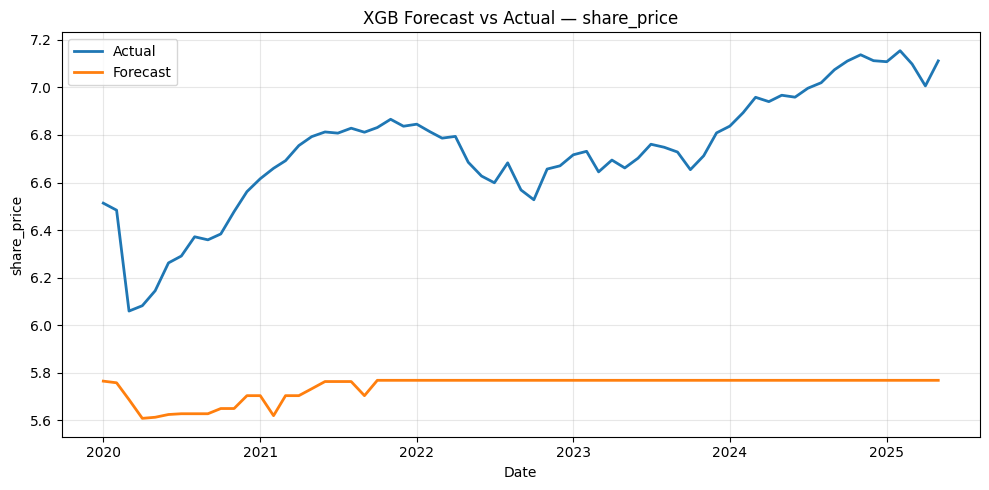

[I 2025-08-28 10:17:44,258] A new study created in memory with name: no-name-f22991c5-7fc0-49ad-bc21-7c5ca47a7104
[I 2025-08-28 10:17:44,338] Trial 0 finished with value: 0.20926742349303998 and parameters: {'n_estimators': 738, 'learning_rate': 0.2858410985317869, 'max_depth': 8, 'min_child_weight': 9.492221567779323, 'subsample': 0.8578938805239198, 'colsample_bytree': 0.9035664135922752, 'gamma': 3.7476731726101593, 'reg_alpha': 4.105721661749214, 'reg_lambda': 0.8829919325210267}. Best is trial 0 with value: 0.20926742349303998.



XGBoost + Optuna Forecasting: unemployment_rate
🔍 DEBUG: Initial train shape: (635, 52), test shape: (65, 52)
🔍 DEBUG: Target unemployment_rate - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 56)
🔍 DEBUG: Lag column nulls: {'unemployment_rate_lag1': 1, 'unemployment_rate_lag3': 3, 'unemployment_rate_lag6': 6, 'unemployment_rate_lag12': 12}
🔍 DEBUG: Using 39 features: ['seasonally_adjusted_CPI', 'CPI_trend', 'seasonally_adjusted_unemployment_rate', 'INDPRO_trend', 'seasonally_adjusted_INDPRO']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_ad

[I 2025-08-28 10:17:44,750] Trial 1 finished with value: 0.18127483620352752 and parameters: {'n_estimators': 1054, 'learning_rate': 0.016077474760003974, 'max_depth': 8, 'min_child_weight': 5.217842866649084, 'subsample': 0.6725037942464466, 'colsample_bytree': 0.9345828315178176, 'gamma': 2.891167967267305, 'reg_alpha': 2.648685655751484, 'reg_lambda': 0.9652363778734132}. Best is trial 1 with value: 0.18127483620352752.
[I 2025-08-28 10:17:44,973] Trial 2 finished with value: 0.15385005913436597 and parameters: {'n_estimators': 1826, 'learning_rate': 0.08933811980038263, 'max_depth': 8, 'min_child_weight': 2.683121593031825, 'subsample': 0.6878271549261631, 'colsample_bytree': 0.6075795992206227, 'gamma': 0.9806989427696217, 'reg_alpha': 4.487747648121653, 'reg_lambda': 4.818843806510611}. Best is trial 2 with value: 0.15385005913436597.
[I 2025-08-28 10:17:45,174] Trial 3 finished with value: 0.17355744433977255 and parameters: {'n_estimators': 245, 'learning_rate': 0.0295166590185

🔧 Best params for unemployment_rate: {'n_estimators': 1089, 'learning_rate': 0.014352882658002147, 'max_depth': 7, 'min_child_weight': 5.413084559107184, 'subsample': 0.7561758506606943, 'colsample_bytree': 0.6835776038224578, 'gamma': 0.24075146688912627, 'reg_alpha': 2.357930410553091, 'reg_lambda': 4.7657396000132}
   Best val RMSE: 0.0934


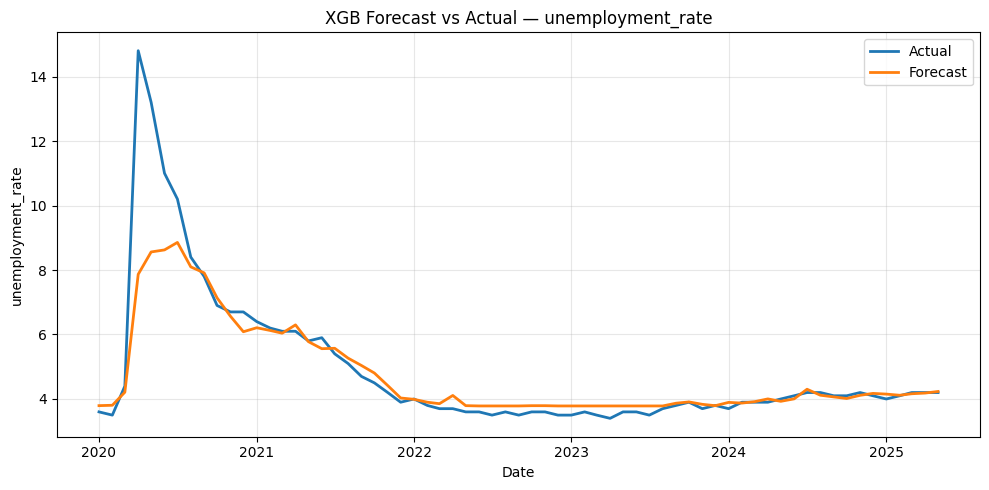

[I 2025-08-28 10:17:55,784] A new study created in memory with name: no-name-dafdd01a-a22e-4ea8-b440-400aeafd0e5d



XGBoost + Optuna Forecasting: PPI
🔍 DEBUG: Initial train shape: (635, 52), test shape: (65, 52)
🔍 DEBUG: Target PPI - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 56)
🔍 DEBUG: Lag column nulls: {'PPI_lag1': 1, 'PPI_lag3': 3, 'PPI_lag6': 6, 'PPI_lag12': 12}
🔍 DEBUG: Using 39 features: ['seasonally_adjusted_CPI', 'CPI_trend', 'seasonally_adjusted_unemployment_rate', 'INDPRO_trend', 'seasonally_adjusted_INDPRO']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDP

[I 2025-08-28 10:17:55,977] Trial 0 finished with value: 19.705676805851013 and parameters: {'n_estimators': 1578, 'learning_rate': 0.24703210573232434, 'max_depth': 8, 'min_child_weight': 3.907643813674388, 'subsample': 0.9431273997860615, 'colsample_bytree': 0.8501611005866605, 'gamma': 2.106295654965016, 'reg_alpha': 1.789005765098598, 'reg_lambda': 2.7632472116248725}. Best is trial 0 with value: 19.705676805851013.
[I 2025-08-28 10:17:56,178] Trial 1 finished with value: 37.900721281676795 and parameters: {'n_estimators': 1821, 'learning_rate': 0.13395231691751183, 'max_depth': 4, 'min_child_weight': 9.116032376795223, 'subsample': 0.6091900329353758, 'colsample_bytree': 0.9693278166004731, 'gamma': 4.729355144268329, 'reg_alpha': 2.1243754950967784, 'reg_lambda': 4.2561892827113255}. Best is trial 0 with value: 19.705676805851013.
[I 2025-08-28 10:17:56,406] Trial 2 finished with value: 39.15344518754282 and parameters: {'n_estimators': 426, 'learning_rate': 0.09941545366288514, 

🔧 Best params for PPI: {'n_estimators': 692, 'learning_rate': 0.20647095295995255, 'max_depth': 8, 'min_child_weight': 3.8657534178725523, 'subsample': 0.9201983958624019, 'colsample_bytree': 0.8548708073377028, 'gamma': 2.116968969419521, 'reg_alpha': 1.923957036075564, 'reg_lambda': 3.0622258435720044}
   Best val RMSE: 15.6752


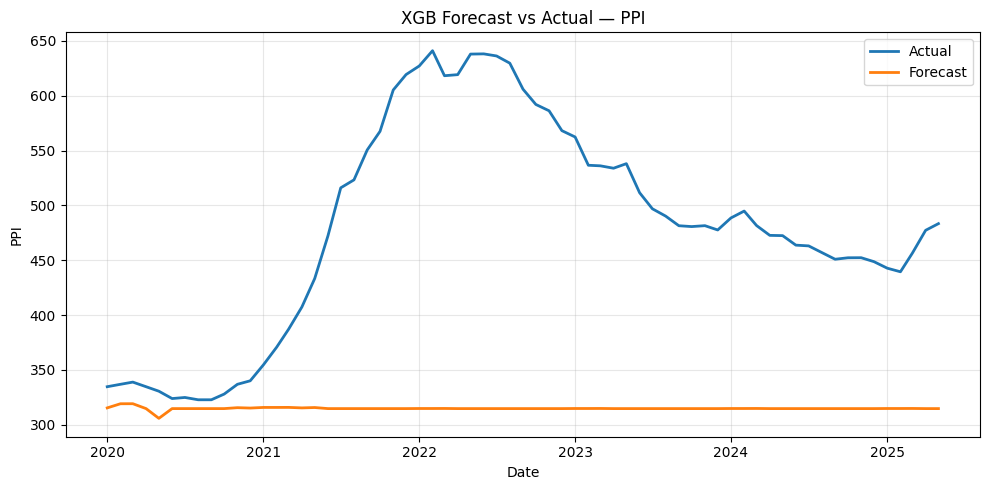

[I 2025-08-28 10:18:11,569] A new study created in memory with name: no-name-def3fa94-1f5d-4414-afd7-39c15571e332



XGBoost + Optuna Forecasting: OECD_CLI_index
🔍 DEBUG: Initial train shape: (635, 52), test shape: (65, 52)
🔍 DEBUG: Target OECD_CLI_index - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 56)
🔍 DEBUG: Lag column nulls: {'OECD_CLI_index_lag1': 1, 'OECD_CLI_index_lag3': 3, 'OECD_CLI_index_lag6': 6, 'OECD_CLI_index_lag12': 12}
🔍 DEBUG: Using 39 features: ['seasonally_adjusted_CPI', 'CPI_trend', 'seasonally_adjusted_unemployment_rate', 'INDPRO_trend', 'seasonally_adjusted_INDPRO']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemploymen

[I 2025-08-28 10:18:11,761] Trial 0 finished with value: 0.15971773387523325 and parameters: {'n_estimators': 247, 'learning_rate': 0.05815209887049278, 'max_depth': 5, 'min_child_weight': 5.011394193010818, 'subsample': 0.8328292382286666, 'colsample_bytree': 0.7292371191568716, 'gamma': 3.111655693563237, 'reg_alpha': 0.9705610854478341, 'reg_lambda': 3.836358853440372}. Best is trial 0 with value: 0.15971773387523325.
[I 2025-08-28 10:18:12,479] Trial 1 finished with value: 0.15025591069653385 and parameters: {'n_estimators': 1699, 'learning_rate': 0.013519606234090036, 'max_depth': 6, 'min_child_weight': 2.8656595314955937, 'subsample': 0.8344351937731882, 'colsample_bytree': 0.854653900551767, 'gamma': 1.4999155124906087, 'reg_alpha': 4.853826727157077, 'reg_lambda': 1.4282395476984666}. Best is trial 1 with value: 0.15025591069653385.
[I 2025-08-28 10:18:12,589] Trial 2 finished with value: 0.15601758784725592 and parameters: {'n_estimators': 715, 'learning_rate': 0.1035649538438

🔧 Best params for OECD_CLI_index: {'n_estimators': 1102, 'learning_rate': 0.04539422761760348, 'max_depth': 3, 'min_child_weight': 1.584738337494271, 'subsample': 0.6651278651456148, 'colsample_bytree': 0.916887665195323, 'gamma': 0.2866852246152672, 'reg_alpha': 1.113279617686043, 'reg_lambda': 0.8312132848201921}
   Best val RMSE: 0.1175


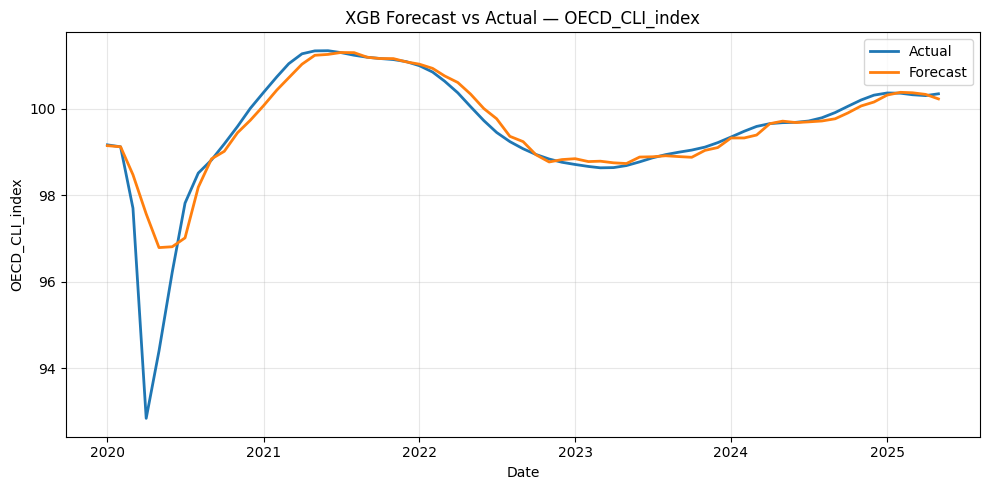

[I 2025-08-28 10:18:22,094] A new study created in memory with name: no-name-6ff54383-10b4-44b9-92b4-7c6fc242479e



XGBoost + Optuna Forecasting: CSI_index
🔍 DEBUG: Initial train shape: (635, 52), test shape: (65, 52)
🔍 DEBUG: Target CSI_index - train nulls: 0, test nulls: 0
🔍 DEBUG: After adding lags, shape: (700, 56)
🔍 DEBUG: Lag column nulls: {'CSI_index_lag1': 1, 'CSI_index_lag3': 3, 'CSI_index_lag6': 6, 'CSI_index_lag12': 12}
🔍 DEBUG: Using 39 features: ['seasonally_adjusted_CPI', 'CPI_trend', 'seasonally_adjusted_unemployment_rate', 'INDPRO_trend', 'seasonally_adjusted_INDPRO']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend

[I 2025-08-28 10:18:22,501] Trial 0 finished with value: 5.042258760483159 and parameters: {'n_estimators': 1919, 'learning_rate': 0.03830736831125202, 'max_depth': 5, 'min_child_weight': 2.0254065391843428, 'subsample': 0.7335325862642005, 'colsample_bytree': 0.9771857468121194, 'gamma': 1.2215833670542509, 'reg_alpha': 4.872164537599294, 'reg_lambda': 0.5780400803779724}. Best is trial 0 with value: 5.042258760483159.
[I 2025-08-28 10:18:22,607] Trial 1 finished with value: 5.2216549253248035 and parameters: {'n_estimators': 631, 'learning_rate': 0.1712852818503824, 'max_depth': 7, 'min_child_weight': 6.173048589377228, 'subsample': 0.7637806936694816, 'colsample_bytree': 0.7209171582348787, 'gamma': 4.981895781083602, 'reg_alpha': 4.732663208275557, 'reg_lambda': 4.604687056767543}. Best is trial 0 with value: 5.042258760483159.
[I 2025-08-28 10:18:22,804] Trial 2 finished with value: 4.219604077580897 and parameters: {'n_estimators': 623, 'learning_rate': 0.0326896364167012, 'max_d

🔧 Best params for CSI_index: {'n_estimators': 1257, 'learning_rate': 0.05069844731515399, 'max_depth': 2, 'min_child_weight': 9.383715224762424, 'subsample': 0.9735489427226055, 'colsample_bytree': 0.9085034729694282, 'gamma': 0.9379165405586367, 'reg_alpha': 1.232445682882549, 'reg_lambda': 4.2498975923306315}
   Best val RMSE: 3.9234


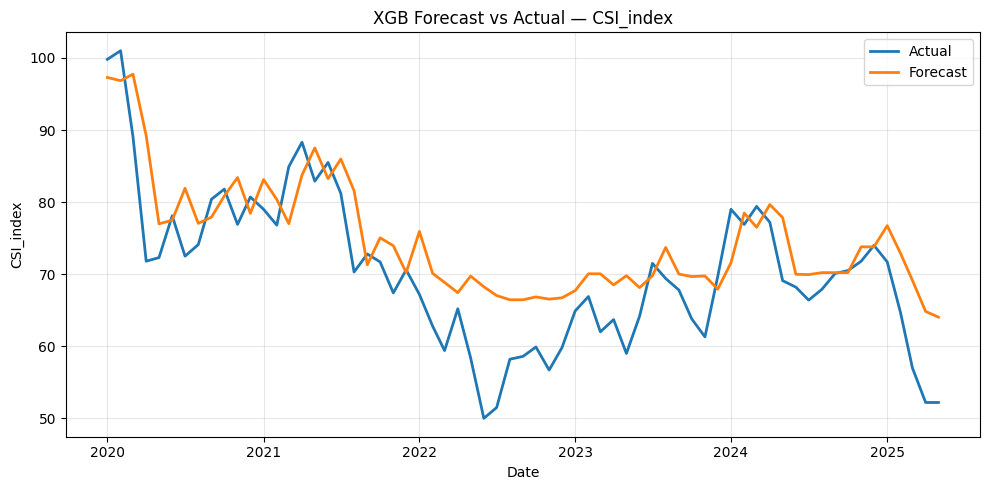

[I 2025-08-28 10:18:32,288] A new study created in memory with name: no-name-896c5ad3-7de9-4c4e-8bfb-1ee68e3272aa



XGBoost + Optuna Forecasting: gdp_per_capita
🔍 DEBUG: Initial train shape: (635, 52), test shape: (65, 52)
🔍 DEBUG: Target gdp_per_capita - train nulls: 0, test nulls: 1
🔍 DEBUG: After adding lags, shape: (700, 56)
🔍 DEBUG: Lag column nulls: {'gdp_per_capita_lag1': 1, 'gdp_per_capita_lag3': 3, 'gdp_per_capita_lag6': 6, 'gdp_per_capita_lag12': 12}
🔍 DEBUG: Using 39 features: ['seasonally_adjusted_CPI', 'CPI_trend', 'seasonally_adjusted_unemployment_rate', 'INDPRO_trend', 'seasonally_adjusted_INDPRO']...
🔍 DEBUG: Before cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemployment_rate: 0 NaNs
   INDPRO_trend: 0 NaNs
   seasonally_adjusted_INDPRO: 0 NaNs
   PPI_trend: 0 NaNs
   unemployment_rate_trend: 0 NaNs
   seasonally_adjusted_PPI: 0 NaNs
   Year: 0 NaNs
   anomaly_INDPRO: 0 NaNs
🔍 DEBUG: After cleaning - NaN counts in features:
   seasonally_adjusted_CPI: 0 NaNs
   CPI_trend: 0 NaNs
   seasonally_adjusted_unemploymen

[I 2025-08-28 10:18:32,630] Trial 0 finished with value: 3470.988976760055 and parameters: {'n_estimators': 737, 'learning_rate': 0.19211229617400075, 'max_depth': 3, 'min_child_weight': 4.341922638054614, 'subsample': 0.9035609602852106, 'colsample_bytree': 0.6240403833886449, 'gamma': 0.5225357404913095, 'reg_alpha': 2.505718316750541, 'reg_lambda': 3.0346143499416884}. Best is trial 0 with value: 3470.988976760055.
[I 2025-08-28 10:18:33,265] Trial 1 finished with value: 3652.7626982102033 and parameters: {'n_estimators': 308, 'learning_rate': 0.01763002783990084, 'max_depth': 7, 'min_child_weight': 8.084983490602577, 'subsample': 0.655343656984634, 'colsample_bytree': 0.696891022343136, 'gamma': 3.601789673423597, 'reg_alpha': 1.8043333331984657, 'reg_lambda': 1.451694813262219}. Best is trial 0 with value: 3470.988976760055.
[I 2025-08-28 10:18:33,749] Trial 2 finished with value: 3490.146704660795 and parameters: {'n_estimators': 1833, 'learning_rate': 0.06546413324472126, 'max_d

🔧 Best params for gdp_per_capita: {'n_estimators': 1134, 'learning_rate': 0.022195267050803293, 'max_depth': 2, 'min_child_weight': 3.196595038984213, 'subsample': 0.8072033683513006, 'colsample_bytree': 0.8681165956646562, 'gamma': 1.8892648350705148, 'reg_alpha': 3.584379506508164, 'reg_lambda': 0.885685796339881}
   Best val RMSE: 3459.5502


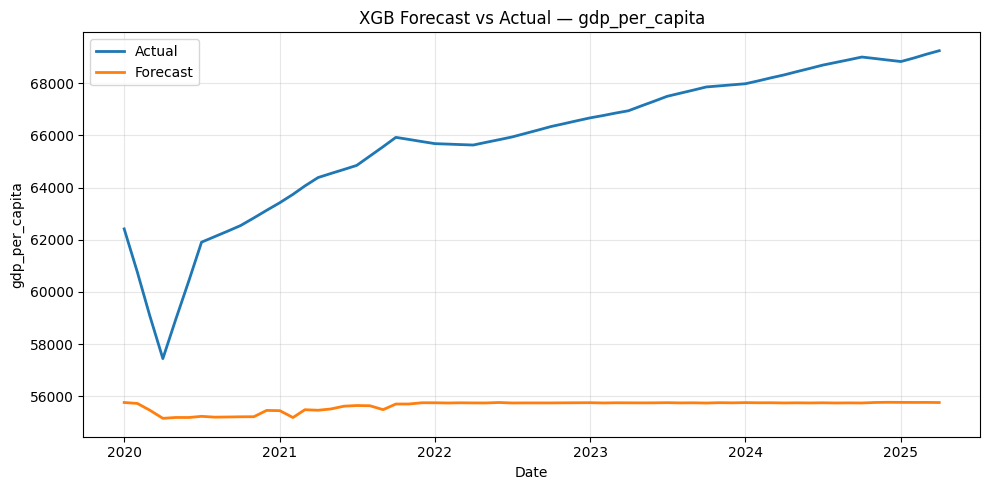


📊 Forecast Performance Metrics (TEST: 2020+)
                          MAE        RMSE    MAPE_%
Indicator                                          
10_year_rate           1.1221      1.5173   98.0956
1_year_rate            0.5039      0.6364  192.5274
3_months_rate          0.4135      0.5271  469.9583
6_months_rate          0.4557      0.5772  418.1147
CPI                   74.5302     77.6532   25.2158
CSI_index              5.7097      7.0793    8.8474
INDPRO                 0.9052      1.1440    0.8983
OECD_CLI_index         0.2465      0.6896    0.2554
PPI                  165.2220    191.9814   31.3962
gdp_per_capita     10165.1558  10490.7922   15.3054
share_price            0.9909      1.0149   14.6173
unemployment_rate      0.3907      1.1066    5.4906


,MAE,RMSE,MAPE_%
Indicator,,,
10_year_rate,1.1221,1.5173,98.0956
1_year_rate,0.5039,0.6364,192.5274
3_months_rate,0.4135,0.5271,469.9583
6_months_rate,0.4557,0.5772,418.1147
CPI,74.5302,77.6532,25.2158
CSI_index,5.7097,7.0793,8.8474
INDPRO,0.9052,1.1440,0.8983
OECD_CLI_index,0.2465,0.6896,0.2554
PPI,165.2220,191.9814,31.3962


In [16]:
# -----------------------------
# USAGE EXAMPLE
# -----------------------------
results = run_xgb_optuna_pipeline(
    dim_reduced_df,
    financial_indicators=financial_indicators,
    recession_targets=recession_targets,
    lags=(1,3,6,12),
    n_trials=40,           # increase for more thorough tuning
    include_exog=True,
    plot_results=True,
    seed=42
)
metrics_table = results["metrics"]
metrics_table